<a href="https://colab.research.google.com/github/wendycataldo/Analise_de_dados_com_Python/blob/main/Aanalise_llm_cruzados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

from google.colab import drive
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy.stats import chi2_contingency

In [33]:
# Montar o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Caminho do arquivo no Google Drive
caminho_avaliacoes = '/content/drive/MyDrive/Analises dados dis/Analise-llms.xlsx'
caminho_questoes = '/content/drive/MyDrive/Analises dados dis/Experimento-questoes.xlsx'
#caminho_avaliacoes_auto = '/content/drive/MyDrive/Analises dados dis/arquivo_avaliacoes_auto.xlsx'

#df_avaliacoes_auto = pd.read_excel(caminho_avaliacoes_auto, sheet_name='Avaliações Automáticas')
df_avaliacoes = pd.read_excel(caminho_avaliacoes, sheet_name='Avaliações Automáticas')
df_questoes = pd.read_excel(caminho_questoes, sheet_name='Questões Geradas')

#1. Qual LLM gera as questões com maior pontuação média em Gramaticalidade?

In [35]:
# Filtrar os dados para incluir apenas as avaliações de Gramaticalidade
df_gramaticalidade = df_avaliacoes[df_avaliacoes['Critério'] == 'Gramaticalidade']

In [36]:
# Imprimir os nomes das colunas para depuração
print(df_gramaticalidade.columns)

Index(['ID_Avaliação', 'ID_Questão', 'LLM_Avaliador', 'Critério', 'Pontuação',
       'Analise llms'],
      dtype='object')


In [37]:
# Calcular a média da pontuação de Gramaticalidade para cada LLM
media_gramaticalidade = df_gramaticalidade.groupby('LLM_Avaliador')['Pontuação'].mean()

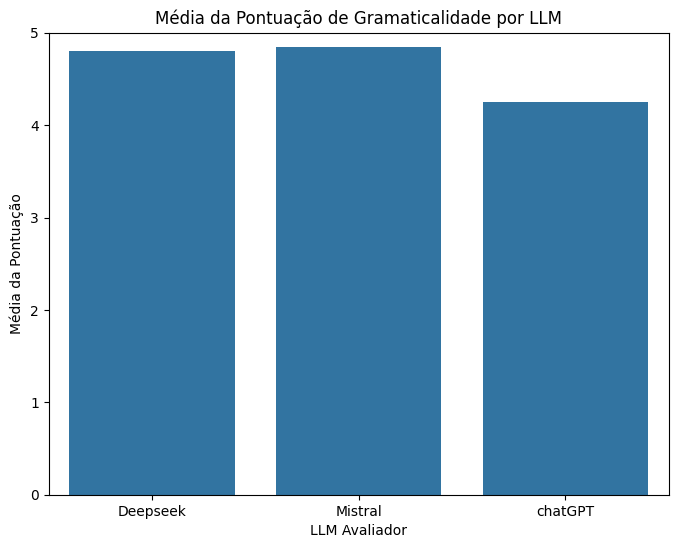

In [38]:
# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=media_gramaticalidade.index, y=media_gramaticalidade.values)
plt.title('Média da Pontuação de Gramaticalidade por LLM')
plt.xlabel('LLM Avaliador')
plt.ylabel('Média da Pontuação')
plt.ylim(0, 5)
plt.show()

In [39]:
# Teste ANOVA (opcional)
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_gramaticalidade['LLM_Avaliador'] = df_gramaticalidade['LLM_Avaliador'].astype('category')
model = ols('Pontuação ~ C(LLM_Avaliador)', data=df_gramaticalidade).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                    sum_sq    df     F    PR(>F)
C(LLM_Avaliador)  4.433333   2.0  13.3  0.000018
Residual          9.500000  57.0   NaN       NaN


/tmp/ipython-input-39-3105386126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gramaticalidade['LLM_Avaliador'] = df_gramaticalidade['LLM_Avaliador'].astype('category')


In [40]:
# Teste post-hoc (se ANOVA for significativo)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=df_gramaticalidade['Pontuação'], groups=df_gramaticalidade['LLM_Avaliador'], alpha=0.05)
print(m_comp)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
Deepseek Mistral     0.05 0.9208 -0.2607  0.3607  False
Deepseek chatGPT    -0.55 0.0002 -0.8607 -0.2393   True
 Mistral chatGPT     -0.6 0.0001 -0.9107 -0.2893   True
-------------------------------------------------------


#2. O Meta-Prompting melhora a Relevância das questões geradas em todos os LLMs?

In [41]:
df_avaliacoes = pd.read_excel(caminho_avaliacoes, sheet_name='Avaliações Automáticas')
df_questoes = pd.read_excel(caminho_questoes, sheet_name='Questões Geradas')

In [42]:
# Imprimir os nomes das colunas do DataFrame df_questoes
print(df_questoes.columns)

Index(['ID_Questão', 'LLM', 'Tipo de Prompt', 'Texto da Questão',
       'Opnição professor'],
      dtype='object')


In [43]:
# Renomear colunas para consistência
df_avaliacoes = df_avaliacoes.rename(columns={'LLM Avaliador': 'LLM'})

In [44]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questoes geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [45]:
# Renomear coluna em df_questoes para consistência antes de combinar
df_questoes = df_questoes.rename(columns={'ID da Questão': 'ID_Questão'})

# Combinar os DataFrames usando a coluna "ID_Questão"
df_combinado = pd.merge(df_avaliacoes[df_avaliacoes['Critério'] == 'Relevância'],
                        df_questoes[['ID_Questão', 'Tipo de Prompt', 'LLM']],
                        on='ID_Questão',
                        suffixes=('_avaliacao', '_questao'))

In [46]:
# Calcular a média de Relevância para cada LLM e tipo de prompt
media_relevancia = df_combinado.groupby(['LLM', 'Tipo de Prompt'])['Pontuação'].mean().unstack()

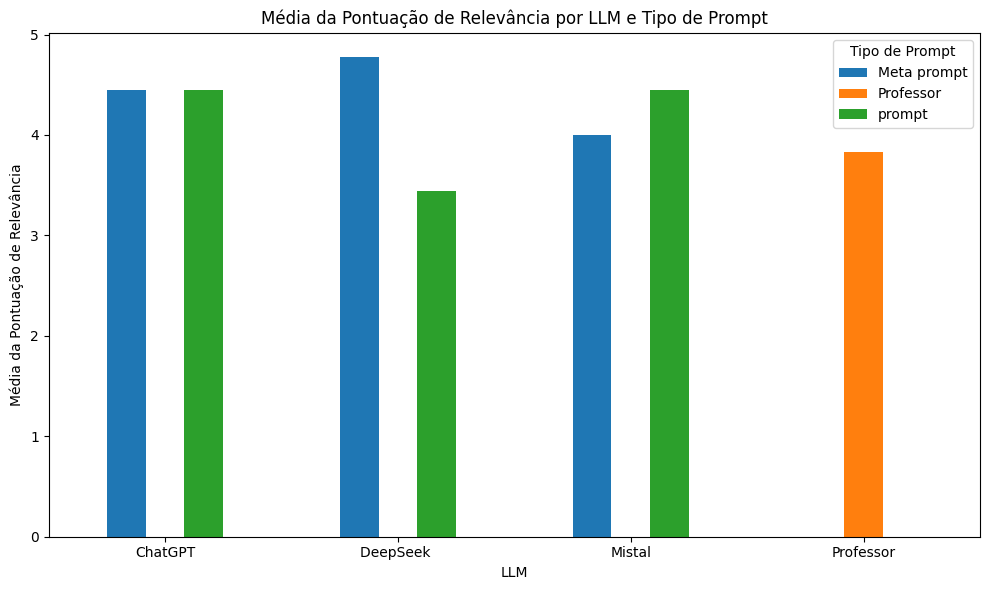

In [47]:
# Criar o gráfico de barras agrupadas
media_relevancia.plot(kind='bar', figsize=(10, 6))
plt.title('Média da Pontuação de Relevância por LLM e Tipo de Prompt')
plt.xlabel('LLM')
plt.ylabel('Média da Pontuação de Relevância')
plt.xticks(rotation=0)
plt.legend(title='Tipo de Prompt')
plt.tight_layout()
plt.show()

In [48]:
# Teste t pareado para cada LLM
for llm in df_combinado['LLM'].unique():
    # Filtrar por LLM
    df_llm = df_combinado[df_combinado['LLM'] == llm]

    # Verificar se há dados suficientes para o teste t
    if len(df_llm['Tipo de Prompt'].unique()) < 2:
        print(f"Não há dados suficientes para o teste t para o LLM {llm}")
        continue

    # Separar as pontuações por tipo de prompt
    relevancia_simples = df_llm[df_llm['Tipo de Prompt'] == 'Simples']['Pontuação']
    relevancia_meta = df_llm[df_llm['Tipo de Prompt'] == 'Meta-Prompting']['Pontuação']

    # Verificar se há dados suficientes para o teste t
    if len(relevancia_simples) < 2 or len(relevancia_meta) < 2:
        print(f"Não há dados suficientes para o teste t para o LLM {llm}")
        continue

    # Realizar o teste t pareado
    teste_t = stats.ttest_rel(relevancia_meta, relevancia_simples)

    # Imprimir os resultados
    print(f"Teste t pareado para {llm}:")
    print(f"  Estatística t: {teste_t.statistic:.3f}")
    print(f"  Valor p: {teste_t.pvalue:.3f}")

    # Interpretar o resultado
    alpha = 0.05
    if teste_t.pvalue < alpha:
        print(f"  Conclusão: O Meta-Prompting melhora significativamente a Relevância para {llm}\n")
    else:
        print(f"  Conclusão: Não há evidência significativa de que o Meta-Prompting melhora a Relevância para {llm}\n")

Não há dados suficientes para o teste t para o LLM Professor
Não há dados suficientes para o teste t para o LLM DeepSeek 
Não há dados suficientes para o teste t para o LLM Mistal
Não há dados suficientes para o teste t para o LLM ChatGPT


# 3. Existem diferenças significativas na Cobertura das questões geradas por ChatGPT e Claude?

In [49]:
# Filtrar os dados para incluir apenas as avaliações de Cobertura e os LLMs ChatGPT e Claude
df_cobertura = df_avaliacoes[(df_avaliacoes['Critério'] == 'Cobertura') & (df_avaliacoes['LLM_Avaliador'].isin(['ChatGPT', 'Claude']))]

In [50]:
# Calcular a média da pontuação de Cobertura para cada LLM
media_cobertura = df_cobertura.groupby('LLM_Avaliador')['Pontuação'].mean()

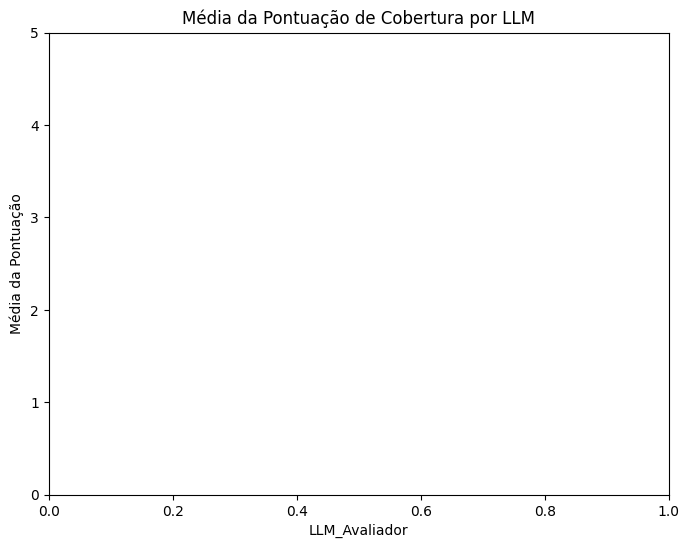

In [51]:
# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=media_cobertura.index, y=media_cobertura.values)
plt.title('Média da Pontuação de Cobertura por LLM')
plt.xlabel('LLM_Avaliador')
plt.ylabel('Média da Pontuação')
plt.ylim(0, 5)
plt.show()

In [52]:
# Realizar o teste t de Student
chatgpt_cobertura = df_cobertura[df_cobertura['LLM_Avaliador'] == 'ChatGPT']['Pontuação']
claude_cobertura = df_cobertura[df_cobertura['LLM_Avaliador'] == 'Claude']['Pontuação']

teste_t = stats.ttest_ind(chatgpt_cobertura, claude_cobertura)

/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [53]:
# Interpretar o resultado
alpha = 0.05
if teste_t.pvalue < alpha:
    print("  Conclusão: Há uma diferença significativa na Cobertura entre ChatGPT e Claude.")
else:
    print("  Conclusão: Não há evidência significativa de uma diferença na Cobertura entre ChatGPT e Claude.")

  Conclusão: Não há evidência significativa de uma diferença na Cobertura entre ChatGPT e Claude.


#5. As justificativas dos LLMs para as pontuações estão alinhadas com as avaliações humanas?

#6. O Meta-Prompting melhora significativamente a qualidade geral das questões geradas pelos LLMs, em comparação com o prompt simples?

In [54]:
# Renomear colunas para consistência
df_avaliacoes = df_avaliacoes.rename(columns={'ID_Questão': 'ID'})
df_questoes = df_questoes.rename(columns={'ID_Questão': 'ID'})

In [55]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questoes geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [56]:
# Agrupar as avaliações por ID da questão para somar as pontuações
df_avaliacoes_agrupadas = df_avaliacoes.groupby('ID')['Pontuação'].sum().reset_index()

In [57]:
# Combinar os DataFrames usando a coluna "ID"
df_combinado = pd.merge(df_avaliacoes_agrupadas,
                        df_questoes[['ID', 'Tipo de Prompt']],
                        on='ID',
                        suffixes=('_avaliacao', '_questao'))

In [58]:
# Calcular a média das pontuações totais para cada tipo de prompt
media_pontuacao_total = df_combinado.groupby('Tipo de Prompt')['Pontuação'].mean()

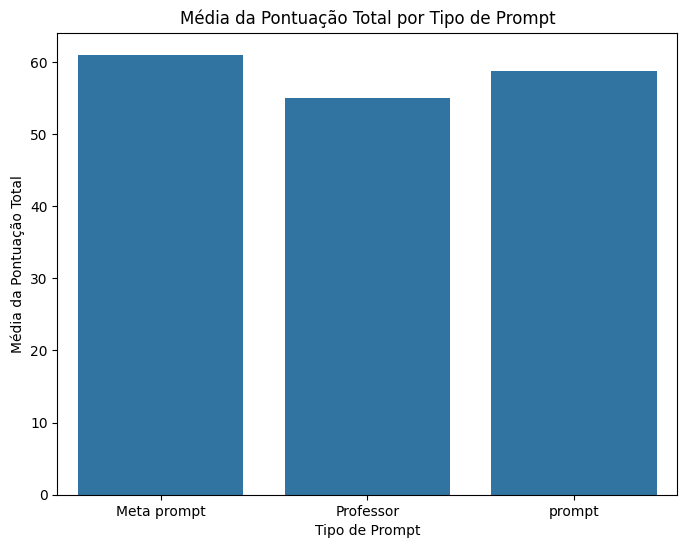

In [59]:
# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=media_pontuacao_total.index, y=media_pontuacao_total.values)
plt.title('Média da Pontuação Total por Tipo de Prompt')
plt.xlabel('Tipo de Prompt')
plt.ylabel('Média da Pontuação Total')
plt.show()

In [60]:
# Realizar o teste t de Student
pontuacao_simples = df_combinado[df_combinado['Tipo de Prompt'] == 'Simples']['Pontuação']
pontuacao_meta = df_combinado[df_combinado['Tipo de Prompt'] == 'Meta-Prompting']['Pontuação']

teste_t = stats.ttest_ind(pontuacao_meta, pontuacao_simples)

/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [61]:
# Imprimir os resultados
print(f"Teste t de Student:")
print(f"  Estatística t: {teste_t.statistic:.3f}")
print(f"  Valor p: {teste_t.pvalue:.3f}")

Teste t de Student:
  Estatística t: nan
  Valor p: nan


In [62]:
# Interpretar o resultado
alpha = 0.05
if teste_t.pvalue < alpha:
    print("  Conclusão: O Meta-Prompting melhora significativamente a qualidade geral das questões.")
else:
    print("  Conclusão: Não há evidência significativa de que o Meta-Prompting melhora a qualidade geral das questões.")

  Conclusão: Não há evidência significativa de que o Meta-Prompting melhora a qualidade geral das questões.


#7. As questões geradas com Meta-Prompting são avaliadas como mais relevantes e adequadas ao conteúdo programático em comparação com as questões geradas com prompt simples e com as questões elaboradas pelo professor?

In [63]:
# Renomear colunas para consistência
df_avaliacoes_auto = df_avaliacoes_auto.rename(columns={'LLM Avaliador': 'LLM', 'ID da Questão': 'ID'})
df_avaliacoes_humanas = df_avaliacoes_humanas.rename(columns={'ID da Questão': 'ID'})
df_questoes = df_questoes.rename(columns={'ID da Questão': 'ID'})

NameError: name 'df_avaliacoes_auto' is not defined

In [ ]:
# Filtrar as avaliações automáticas para incluir apenas a relevância
df_relevancia_auto = df_avaliacoes_auto[df_avaliacoes_auto['Critério'] == 'Relevância']

In [ ]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questões Geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [ ]:
# Criar uma coluna "Fonte" para identificar a fonte da questão (LLM Simples, LLM Meta-Prompting, Professor)
df_relevancia_auto = pd.merge(df_relevancia_auto, df_questoes[['ID', 'Tipo de Prompt']], on='ID', how='left')
df_relevancia_auto['Fonte'] = df_relevancia_auto['Tipo de Prompt'].apply(lambda x: f'LLM {x}' if pd.notnull(x) else None)

In [ ]:
# Adicionar as avaliações humanas
df_avaliacoes_humanas['Fonte'] = 'Professor'
df_relevancia_humana = df_avaliacoes_humanas[['ID', 'LLM', 'Tipo de Prompt', 'Fonte', 'Pontuação']]

In [ ]:
# Concatenar os DataFrames
df_combinado = pd.concat([df_relevancia_auto[['ID', 'LLM', 'Tipo de Prompt', 'Fonte', 'Pontuação']], df_relevancia_humana], ignore_index=True)

In [ ]:
# Calcular a média da pontuação de Relevância para cada fonte da questão
media_relevancia = df_combinado.groupby('Fonte')['Pontuação'].mean()

In [ ]:
# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=media_relevancia.index, y=media_relevancia.values)
plt.title('Média da Pontuação de Relevância por Fonte da Questão')
plt.xlabel('Fonte da Questão')
plt.ylabel('Média da Pontuação de Relevância')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Remover linhas com valores nulos na coluna 'Fonte'
df_combinado = df_combinado.dropna(subset=['Fonte'])

In [ ]:
# Teste ANOVA
model = ols('Pontuação ~ C(Fonte)', data=df_combinado).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [ ]:
# Teste post-hoc de Tukey (se ANOVA for significativo)
m_comp = pairwise_tukeyhsd(endog=df_combinado['Pontuação'], groups=df_combinado['Fonte'], alpha=0.05)
print(m_comp)

#8. O Meta-Prompting resulta em questões mais personalizadas e contextualizadas em comparação com o prompt simples?

In [ ]:
# Carregar os dados (substitua pelos caminhos corretos)
from google.colab import drive
drive.mount('/content/drive')
caminho_avaliacoes = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_avaliacoes.xlsx'
caminho_questoes = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_questoes.xlsx'

df_avaliacoes = pd.read_excel(caminho_avaliacoes, sheet_name='Avaliações Automáticas')
df_questoes = pd.read_excel(caminho_questoes, sheet_name='Questões Geradas')

In [ ]:
# Renomear colunas para consistência
df_avaliacoes = df_avaliacoes.rename(columns={'LLM Avaliador': 'LLM', 'ID da Questão': 'ID'})
df_questoes = df_questoes.rename(columns={'ID da Questão': 'ID'})

In [ ]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questoes geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [ ]:
# Filtrar as avaliações para incluir apenas a utilidade e relevância
df_utilidade = df_avaliacoes[df_avaliacoes['Critério'] == 'Utilidade']
df_relevancia = df_avaliacoes[df_avaliacoes['Critério'] == 'Relevância']

In [ ]:
# Combinar os DataFrames usando a coluna "ID"
df_combinado_utilidade = pd.merge(df_utilidade,
                        df_questoes[['ID', 'Tipo de Prompt']],
                        on='ID',
                        suffixes=('_avaliacao', '_questao'))

df_combinado_relevancia = pd.merge(df_relevancia,
                        df_questoes[['ID', 'Tipo de Prompt']],
                        on='ID',
                        suffixes=('_avaliacao', '_questao'))

In [ ]:
# Calcular a média de Utilidade e Relevância para cada tipo de prompt
media_utilidade = df_combinado_utilidade.groupby('Tipo de Prompt')['Pontuação'].mean()
media_relevancia = df_combinado_relevancia.groupby('Tipo de Prompt')['Pontuação'].mean()

In [ ]:
# Criar os gráficos de barras
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x=media_utilidade.index, y=media_utilidade.values, ax=axes[0])
axes[0].set_title('Média da Pontuação de Utilidade por Tipo de Prompt')
axes[0].set_xlabel('Tipo de Prompt')
axes[0].set_ylabel('Média da Pontuação de Utilidade')

sns.barplot(x=media_relevancia.index, y=media_relevancia.values, ax=axes[1])
axes[1].set_title('Média da Pontuação de Relevância por Tipo de Prompt')
axes[1].set_xlabel('Tipo de Prompt')
axes[1].set_ylabel('Média da Pontuação de Relevância')

plt.tight_layout()
plt.show()

#9. Quais são as vantagens específicas do Meta-Prompting na criação de exercícios, identificadas tanto pelas avaliações automáticas dos LLMs quanto pelas avaliações humanas dos professores?

In [ ]:
import pandas as pd

In [ ]:
# Carregar os dados (substitua pelos caminhos corretos)
from google.colab import drive
drive.mount('/content/drive')
caminho_avaliacoes_auto = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_avaliacoes_auto.xlsx'
caminho_avaliacoes_humanas = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_avaliacoes_humanas.xlsx'
caminho_questoes = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_questoes.xlsx'

df_avaliacoes_auto = pd.read_excel(caminho_avaliacoes_auto, sheet_name='Avaliações Automáticas')
df_avaliacoes_humanas = pd.read_excel(caminho_avaliacoes_humanas, sheet_name='Avaliações Humanas')
df_questoes = pd.read_excel(caminho_questoes, sheet_name='Questões Geradas')

In [ ]:
# Renomear colunas para consistência
df_avaliacoes_auto = df_avaliacoes_auto.rename(columns={'LLM Avaliador': 'LLM', 'ID da Questão': 'ID'})
df_avaliacoes_humanas = df_avaliacoes_humanas.rename(columns={'ID da Questão': 'ID'})
df_questoes = df_questoes.rename(columns={'ID da Questão': 'ID'})

In [ ]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questoes geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [ ]:
# Filtrar as questões geradas com Meta-Prompting
df_questoes_meta = df_questoes[df_questoes['Tipo de Prompt'] == 'Meta-Prompting']

In [ ]:
# Combinar as avaliações automáticas com as questões Meta-Prompting
df_avaliacoes_meta = pd.merge(df_avaliacoes_auto, df_questoes_meta[['ID']], on='ID', how='inner')

In [ ]:
# Extrair as justificativas dos LLMs para as questões Meta-Prompting
justificativas_llms = df_avaliacoes_meta['Justificativa'].tolist()

In [ ]:
# Extrair os comentários dos professores para as questões Meta-Prompting
comentarios_professores = []
for index, row in df_avaliacoes_humanas.iterrows():
  if row['ID'] in df_questoes_meta['ID'].values:
      comentarios_professores.append(row['Comentários'])

In [ ]:
# Extrair os comentários dos professores para as questões Meta-Prompting
comentarios_professores = []
for index, row in df_avaliacoes_humanas.iterrows():
  if row['ID'] in df_questoes_meta['ID'].values:
      comentarios_professores.append(row['Comentários'])

#10. As questões geradas com Meta-Prompting são consideradas de qualidade e relevância suficientes para serem utilizadas por professores de Língua Portuguesa em suas aulas?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Carregar os dados (substitua pelos caminhos corretos)
from google.colab import drive
drive.mount('/content/drive')
caminho_avaliacoes_humanas = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_avaliacoes_humanas.xlsx'
caminho_questoes = '/content/drive/My Drive/Colab Notebooks/Data/seu_arquivo_questoes.xlsx'

df_avaliacoes_humanas = pd.read_excel(caminho_avaliacoes_humanas, sheet_name='Avaliações Humanas')
df_questoes = pd.read_excel(caminho_questoes, sheet_name='Questões Geradas')

In [ ]:
# Renomear colunas para consistência
df_avaliacoes_humanas = df_avaliacoes_humanas.rename(columns={'ID da Questão': 'ID'})
df_questoes = df_questoes.rename(columns={'ID da Questão': 'ID'})

In [ ]:
# Extrair o tipo de prompt da coluna "Tipo de Prompt" na aba "Questoes geradas"
df_questoes['Tipo de Prompt'] = df_questoes['Tipo de Prompt'].replace({'Meta': 'Meta-Prompting', 'Simples': 'Simples'})

In [ ]:
# Filtrar as questões geradas com Meta-Prompting
df_questoes_meta = df_questoes[df_questoes['Tipo de Prompt'] == 'Meta-Prompting']

In [ ]:
# Combinar as avaliações humanas com as questões Meta-Prompting
df_avaliacoes_meta = pd.merge(df_avaliacoes_humanas, df_questoes_meta[['ID']], on='ID', how='inner')

In [ ]:
# Calcular a porcentagem de questões com Meta-Prompting que recebem pontuações altas (4 ou 5) em Utilidade e Relevância
pontuacao_minima = 4
total_questoes_meta = len(df_avaliacoes_meta)

utilidade_alta = df_avaliacoes_meta[df_avaliacoes_meta['Utilidade'] >= pontuacao_minima]
relevancia_alta = df_avaliacoes_meta[df_avaliacoes_meta['Relevância'] >= pontuacao_minima]

porcentagem_utilidade_alta = (len(utilidade_alta) / total_questoes_meta) * 100
porcentagem_relevancia_alta = (len(relevancia_alta) / total_questoes_meta) * 100

In [ ]:
# Imprimir as porcentagens
print(f"Porcentagem de questões Meta-Prompting com pontuação de Utilidade >= {pontuacao_minima}: {porcentagem_utilidade_alta:.2f}%")
print(f"Porcentagem de questões Meta-Prompting com pontuação de Relevância >= {pontuacao_minima}: {porcentagem_relevancia_alta:.2f}%")